# Caption Analysis

In [1]:
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import openai

In [2]:
encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [9]:
# 
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [10]:
df = pd.read_csv("clean_cartoon.csv")

In [11]:
length_cap_1s = []
length_cap_2s = []
num_tok_cap_1s = []
num_tok_cap_2s = []
for i in range(len(df)):
    row = df.iloc[i]
    id, img, caption_1, valid, qa, caption_2, sub_imgs, duplicate, caption = row
    length_cap_1 = len(caption_1.split(" "))
    length_cap_1s.append(length_cap_1)
    length_cap_2 = len(caption_2.split(" "))
    length_cap_2s.append(length_cap_2)
    num_tok_cap_1 = num_tokens_from_string(caption_1, "cl100k_base")
    num_tok_cap_1s.append(num_tok_cap_1)
    num_tok_cap_2 = num_tokens_from_string(caption_2, "cl100k_base")
    num_tok_cap_2s.append(num_tok_cap_2)

In [12]:
cap = pd.DataFrame([])
cap["len_cap_1"] = length_cap_1s
cap["len_cap_2"] = length_cap_2s
cap["len_tok_1"] = num_tok_cap_1s
cap["len_tok_2"] = num_tok_cap_2s

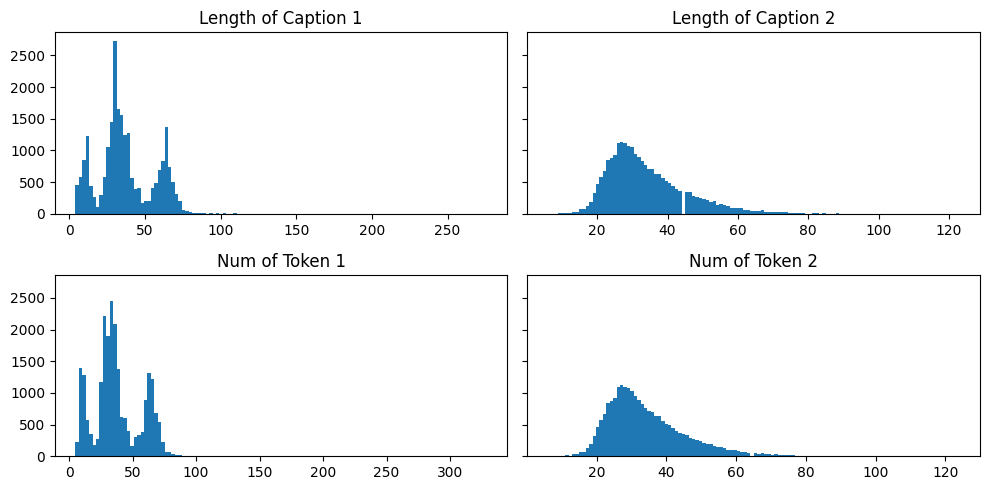

In [13]:

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10,5))

# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(cap["len_cap_1"], bins=120)
axs[0, 0].set_title('Length of Caption 1')
axs[0, 1].hist(cap["len_cap_2"], bins=120)
axs[0, 1].set_title('Length of Caption 2')
axs[1, 0].hist(cap["len_tok_1"], bins=120)
axs[1, 0].set_title('Num of Token 1')
axs[1, 1].hist(cap["len_tok_2"], bins=120)
axs[1, 1].set_title('Num of Token 2')
plt.show()

In [14]:
cap.describe()

,len_cap_1,len_cap_2,len_tok_1,len_tok_2
count,23496.000000,23496.000000,23496.000000,23496.000000
mean,37.280856,34.048476,38.156793,34.199736
std,18.944939,11.411385,19.412423,11.515375
min,4.000000,6.000000,5.000000,6.000000
25%,27.000000,26.000000,27.000000,26.000000
50%,34.000000,32.000000,34.000000,32.000000
75%,53.000000,40.000000,54.000000,40.000000
max,276.000000,123.000000,329.000000,124.000000


In [15]:
print(f"Captain 1's total tokens are: {cap['len_cap_1'].sum()} tokens")
print(f"Captain 2's total tokens are: {cap['len_cap_2'].sum()} tokens")

Captain 1's total tokens are: 875951 tokens
Captain 2's total tokens are: 800003 tokens


# Promt Analysis

In [16]:
requirement = "you are required to ask about 10 questions about a given context. " + \
    "The question topics are: yes/no, counting, object, activity, " + \
    "color, posistion. Answer within 3 words.\n" + \
    "context: a man is jumping to catch a ball.\n" + \
    "output:1. What is he doing?\nJumping.\n2. What sport is he playing?\nFootball.\n3. What color is the ball?\nUnknown."

In [17]:
#Create Promts
def promt(caption_1, requiremnt):
    return f"{requiremnt}\ncontext: {caption_1}\noutput:"

cap["cap_1"] = df["caption_1"]
cap["cap_2"] = df["caption_2"]
cap["promt_1"] = cap["cap_1"].apply(lambda x: promt(x, requirement))
cap["promt_2"] = cap["cap_2"].apply(lambda x: promt(x, requirement))

# Word and Token Counting
cap["len_promt_1"] = cap["promt_1"].apply(lambda x: len(x.split(" ")))
cap["len_promt_2"] = cap["promt_2"].apply(lambda x: len(x.split(" ")))
cap["len_promt_tok_1"] = cap["promt_1"].apply(lambda x: num_tokens_from_string(x, encoding_name="cl100k_base"))
cap["len_promt_tok_2"] = cap["promt_2"].apply(lambda x: num_tokens_from_string(x, encoding_name="cl100k_base"))

In [18]:
#Combint a promt using 2 captions
requirement2 = "You are required to ask about 10 questions about 2 given contexts. " + \
    "The question topics are: yes/no, counting, object, activity, " + \
    "color, posistion. Answer within 3 words.\n" + \
    "context 1: a man is jumping to catch a ball.\n" + \
    "context 2: a white ball is being catch by a man.\n" + \
    "output:1. What is he doing?\nJumping.\n2. What sport is he playing?\nFootball.\n3. What color is the ball?\nwhite."
def combined_promt(caption_1, caption_2, requirement):
    
    return f"{requirement}\ncontext 1: {caption_1} \ncontext 2: {caption_2}\noutput:"

cap['promt_3'] = cap[['cap_1', 'cap_2']].apply(lambda row: combined_promt(row['cap_1'], row['cap_2'], requirement2), axis=1)
cap["len_promt_3"] = cap["promt_3"].apply(lambda x: len(x.split(" ")))
cap["len_promt_tok_3"] = cap["promt_3"].apply(lambda x: num_tokens_from_string(x, encoding_name="cl100k_base"))

In [19]:
cap[["len_promt_1", "len_promt_tok_1","len_promt_2", "len_promt_tok_2", "len_promt_3", "len_promt_tok_3"]].describe()

,len_promt_1,len_promt_tok_1,len_promt_2,len_promt_tok_2,len_promt_3,len_promt_tok_3
count,23496.000000,23496.000000,23496.000000,23496.000000,23496.000000,23496.000000
mean,85.280856,126.156580,82.048476,122.199736,133.329333,184.356316
std,18.944939,19.412651,11.411385,11.515375,21.847481,22.294075
min,52.000000,93.000000,54.000000,94.000000,74.000000,124.000000
25%,75.000000,115.000000,74.000000,114.000000,118.000000,169.000000
50%,82.000000,122.000000,80.000000,120.000000,130.000000,181.000000
75%,101.000000,142.000000,88.000000,128.000000,149.000000,200.000000
max,324.000000,417.000000,171.000000,212.000000,372.000000,464.000000


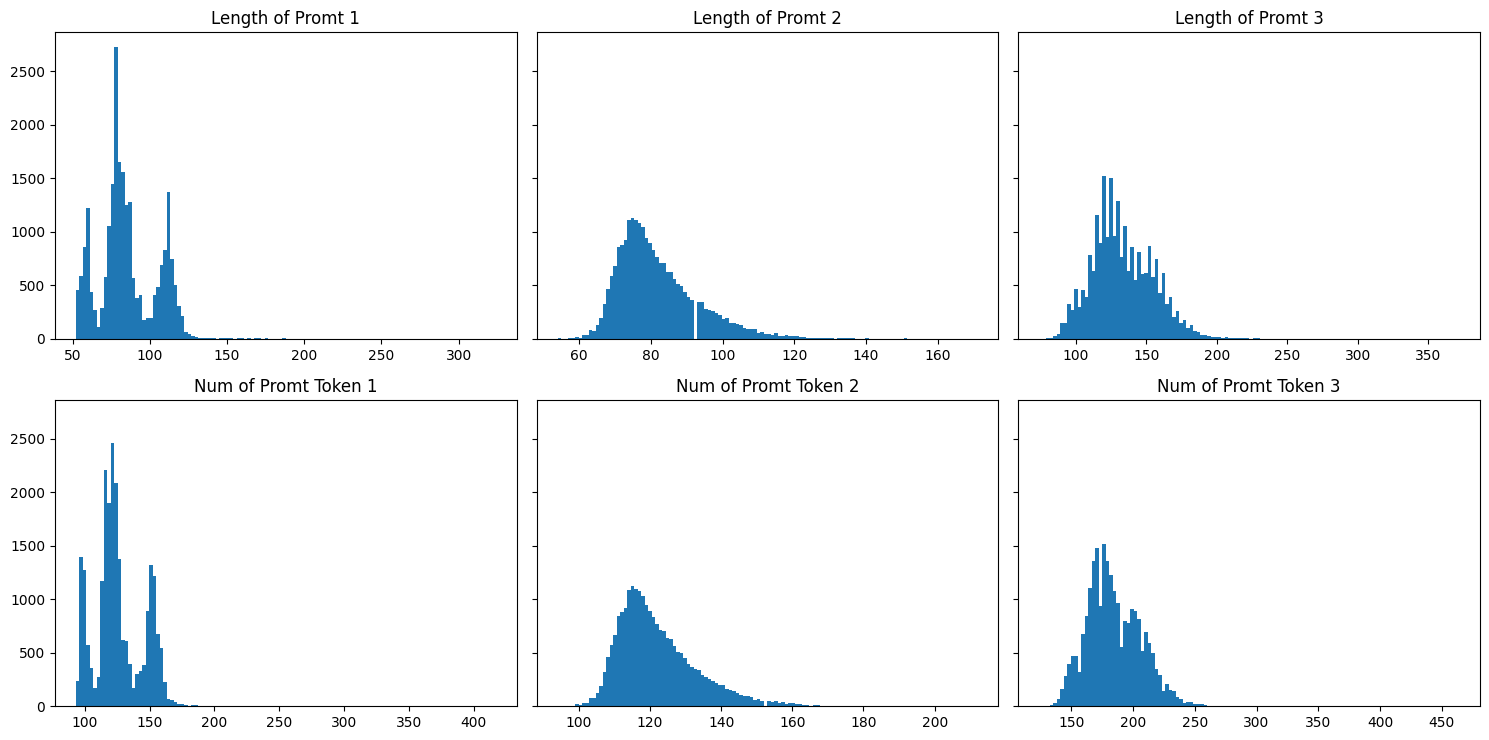

In [20]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True, figsize=(15,7.5))

# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].hist(cap["len_promt_1"], bins=120)
axs[0, 0].set_title('Length of Promt 1')
axs[0, 1].hist(cap["len_promt_2"], bins=120)
axs[0, 1].set_title('Length of Promt 2')
axs[0, 2].hist(cap["len_promt_3"], bins=120)
axs[0, 2].set_title('Length of Promt 3')

axs[1, 0].hist(cap["len_promt_tok_1"] , bins=120)
axs[1, 0].set_title('Num of Promt Token 1')
axs[1, 1].hist(cap["len_promt_tok_2"] , bins=120)
axs[1, 1].set_title('Num of Promt Token 2')
axs[1, 2].hist(cap["len_promt_tok_3"] , bins=120)
axs[1, 2].set_title('Num of Promt Token 3')
plt.show()

In [21]:
cap['promt_1'][1]

'you are required to ask about 10 questions about a given context. The question topics are: yes/no, counting, object, activity, color, posistion. Answer within 3 words.\ncontext: a man is jumping to catch a ball.\noutput:1. What is he doing?\nJumping.\n2. What sport is he playing?\nFootball.\n3. What color is the ball?\nUnknown.\ncontext: a cartoon man is standing in front of a counter the man is wearing a white shirt and blue pants the man has a stick in his hand\noutput:'

In [22]:
for i in range(2):
    print("#"*50)
    print(f"Promt 1\n{cap['promt_1'][i]}")
    print("-"*20)
    print(f"Promt 2\n{cap['promt_2'][i]}")
    print("-"*20)
    print(f"Promt 3\n{cap['promt_3'][i]}")

##################################################
Promt 1
you are required to ask about 10 questions about a given context. The question topics are: yes/no, counting, object, activity, color, posistion. Answer within 3 words.
context: a man is jumping to catch a ball.
output:1. What is he doing?
Jumping.
2. What sport is he playing?
Football.
3. What color is the ball?
Unknown.
context: the simpsons homer simpson wallpaper cartoon wallpapers 1920x1080
output:
--------------------
Promt 2
you are required to ask about 10 questions about a given context. The question topics are: yes/no, counting, object, activity, color, posistion. Answer within 3 words.
context: a man is jumping to catch a ball.
output:1. What is he doing?
Jumping.
2. What sport is he playing?
Football.
3. What color is the ball?
Unknown.
context: in this image i can see a man and a woman standing and holding a cup in their hands in the background i can also see a microwave oven and some cabinets
output:
--------------

In [23]:
#USD0.002 / 1K tokens
def estimate_price(total_token):
    return (total_token/1000)*0.002

In [24]:
print(f"Promt 1's total tokens are: {cap['len_promt_tok_1'].sum()} tokens    =>  PRICE: US$ {round(estimate_price(cap['len_promt_tok_1'].sum()), 2)}")
print(f"Promt 2's total tokens are: {cap['len_promt_tok_2'].sum()} tokens    =>  PRICE: US$ {round(estimate_price(cap['len_promt_tok_2'].sum()), 2)}")
print(f"Promt 3's total tokens are: {cap['len_promt_tok_3'].sum()} tokens    =>  PRICE: US$ {round(estimate_price(cap['len_promt_tok_3'].sum()), 2)}")

Promt 1's total tokens are: 2964175 tokens    =>  PRICE: US$ 5.93
Promt 2's total tokens are: 2871205 tokens    =>  PRICE: US$ 5.74
Promt 3's total tokens are: 4331636 tokens    =>  PRICE: US$ 8.66


# Question-Answering Generation

In [25]:
file_path = "../../openai_key.txt"

with open(file_path, "r") as file:
    key = file.read()

In [26]:
import os
import openai
openai.api_key = key
from time import sleep
import pickle

def get_questions_anwers(promt):
    
    completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user",
         "content": promt}
    ])
    questions_answers = completion.choices[0].message.content
    return questions_answers

# Question-Answer Analysis

In [27]:
"""
QAs_1 = []
for i in range(100):
    print("-"*30)
    print(i)
    success = False
    while not success:
        try:
            row = cap.iloc[i]
            promt_1, promt_2, promt_3 = row["promt_1"], row["promt_2"], row["promt_3"]
            qa = get_questions_anwers(promt_3)
            QAs_3.append(qa)
            success = True
        except:
            
            print("re-trying")
            sleep(10)

with open('result3.pkl', 'wb') as f:
    pickle.dump(QAs_3, f)    
"""   


'\nQAs_1 = []\nfor i in range(100):\n    print("-"*30)\n    print(i)\n    success = False\n    while not success:\n        try:\n            row = cap.iloc[i]\n            promt_1, promt_2, promt_3 = row["promt_1"], row["promt_2"], row["promt_3"]\n            qa = get_questions_anwers(promt_3)\n            QAs_3.append(qa)\n            success = True\n        except:\n            \n            print("re-trying")\n            sleep(10)\n\nwith open(\'result3.pkl\', \'wb\') as f:\n    pickle.dump(QAs_3, f)    \n'

In [29]:
with open('result1.pkl', 'rb') as f:
 result1 = pickle.load(f)
f.close()
with open('result2.pkl', 'rb') as f:
 result2 = pickle.load(f)
f.close()
with open('result3.pkl', 'rb') as f:
 result3 = pickle.load(f)
f.close()

In [30]:
def qa_processing(string):
    lines = string.split('\n')
    
    # Extract the question lines (odd indices)
    questions = [line.split('. ')[1] for line in lines[::2]]
    
    # Extract the answer lines (even indices)
    answers = [line for line in lines[1::2]]
    return questions, answers


In [31]:
questions1 = []
answers1 = []
questions2 = []
answers2 = []
questions3 = []
answers3 = []
for i in range(100):
    try:
        q1, a1 = qa_processing(result1[i])
        questions1 += q1
        answers1 += a1
        q2, a2 = qa_processing(result2[i])
        questions2 += q2
        answers2 += a2
        q3, a3 = qa_processing(result3[i])
        questions3 += q3
        answers3 += a3
    except:
        pass
qa_df = pd.DataFrame([])
qa_df["question 1"] = questions1[:740]
qa_df["answer 1"] = answers1[:740]
qa_df["question 2"] = questions2[:740]
qa_df["answer 2"] = answers2[:740]
qa_df["question 3"] = questions3[:740]
qa_df["answer 3"] = answers3[:740]

In [32]:
qa_df

,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,Is it a cartoon?,Yes.,Are they holding one cup or more?,Unknown.,Is it a cartoon?,Yes.
1,How many characters are there?,Multiple.,How many people are there?,Two.,How many characters are visible?,Two.
2,What is the main character's name?,Homer.,What are they holding?,Cup.,What are they holding?,Cup.
3,What is on the wallpaper?,Simpsons cartoon.,What is in the background?,"Microwave, cabinets.",What color are the cabinets?,Unknown.
4,What is the resolution?,1920x1080.,What color is the cup?,Unknown.,What position are they in?,Standing.
...,...,...,...,...,...,...
735,Is the man in the cartoon human?,Yes.,What color is the door?,Purple.,Is the person wearing glasses?,Yes.
736,What is the show called?,The Simpsons.,What is the person holding?,Object.,What is the person's job?,Not specified.
737,What type of building is it?,Unknown.,Is the person standing or sitting?,Unknown.,Are there people?,Yes.
738,Is it a comedy?,Yes.,How many people are in the image?,1.,How many people?,Unknown.


In [33]:
qa_df.describe() 

,question 1,answer 1,question 2,answer 2,question 3,answer 3
count,740,740,740,740,740,740
unique,598,189,500,175,510,301
top,Is there a person in the image?,Unknown.,What is in the background?,Unknown.,What is in the background?,Yes.
freq,10,233,22,241,31,104


According to the above table, the option 3 is the best option since the most appearance of answers in "Yes" instead of "Unknown"